# TRABALHO PRÁTICO -- PROCESSAMENTO DE IMAGENS DIGITAIS
|**Participantes**|**RA**|
|-|-|
|Gustavo M. Barreto|790832|



## ATIVIDADE 1.0:

Quantificação volumétrica das substâncias branca (WM), cinzenta (GM) e líquido cefalorraquidiano (CSF) do cérebro humano em imagens de Ressonância Magnética (MR), utilizando segmentação não supervisionada (K-Médias) e atlas probabilísticos dos tecidos cerebrais.

In [58]:
# Instalacao de Pacotes e ambiente
#!python3 -m venv pdi_env
#source pdi_env/bin/activate
!python3 -m pip install -r requirements.txt
#!python3 -m pip freeze > requirements.txt


In [55]:
import numpy as np
import SimpleITK as sitk
import itkwidgets, os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_nl_means, estimate_sigma

#importando funcoes miscelania -- apresentacao de cortes e outros
from jupyter_misc import *



# 1. Analise Geral das Imagens:
Observamos os tamanhos de voxels e espaçamento de imagem, permitindo observar caso haja a necessidade do uso de interpolações de acordo com o tamanho de imagem. 



In [166]:
ATLAS_DIR   = 'Atlas'
ref_image = 'mni_ref.nii.gz'

masks  = os.listdir(ATLAS_DIR)
masks.remove('mni_ref.nii.gz')

#encadeia todas as mascaras em uma lista
atlas = [sitk.ReadImage(f"{ATLAS_DIR}/{mask}") for mask in masks]

ref   = sitk.ReadImage(f"{ATLAS_DIR}/{ref_image}")

print(".: Dados sobre as mascaras :. ")
images_info(atlas)

print(".: Dados sobre a imagem referencia :. ")
images_info([ref])



.: Dados sobre as mascaras :. 
Size(total voxels):      (256, 256, 256)
Spacing(between voxels): (1.0, 1.0, 1.0)
Width, Height and Depth: 256 x 256 x 256
Dimension:               3
----------------------------
Size(total voxels):      (256, 256, 256)
Spacing(between voxels): (1.0, 1.0, 1.0)
Width, Height and Depth: 256 x 256 x 256
Dimension:               3
----------------------------
Size(total voxels):      (256, 256, 256)
Spacing(between voxels): (1.0, 1.0, 1.0)
Width, Height and Depth: 256 x 256 x 256
Dimension:               3
----------------------------
Size(total voxels):      (256, 256, 256)
Spacing(between voxels): (1.0, 1.0, 1.0)
Width, Height and Depth: 256 x 256 x 256
Dimension:               3
----------------------------
.: Dados sobre a imagem referencia :. 
Size(total voxels):      (256, 256, 256)
Spacing(between voxels): (1.0, 1.0, 1.0)
Width, Height and Depth: 256 x 256 x 256
Dimension:               3
----------------------------


## 1.1 Redução de ruído de Imagens(denoising)
A redução de ruído deve ser realizada de forma cautelosa, visto a possibilidade de comprometimento de informações importantes dentro de uma imagem. Dessa forma, avaliaremos diferentes tipos de filtragens de ruído, das quais: 
- Filtro de Bilateral;
- Filtro de Difusão Anisotrópica ;
- Filtro de Média Não-Local; 

Seus detalhes serão discutidos em cada seção, separadamente.


### a) Filtro Bilateral
O filtro Bilateral tem como definição uma média ponderada de pixels vizinhos, de forma muito similar ao caso de Convolução Gaussiana. Sua diferença permeia sobre considerar a preservação de suas bordas. Formalmente:

$$
I = \dfrac{1}{W_p} = \sum G_s(||p-q||) G_\theta(|I_p - I_q) I_q
$$

Por sua vez, este filtro tem por objetivo normalizar intervalos de imagem mas também considerando a questão de desníveis abruptos na imagem, pois desníveis na imagem também são levados em consideração na imagem de entrada. 


<img src='img/bf.png'>



### Programação do Filtro Bilateral - Sitk

In [ ]:
def bilateral_filter(image, domain_sigma, range_sigma):
    
    b_filter = sitk.BilateralImageFilter()
    b_filter.SetDomainSigma(domain_sigma)
    b_filter.SetRangeSigma(range_sigma)
    
    #return filtered image
    return b_filter.Execute(image)


### b) Filtro de Difusão Anisotrópica

O filtro de difusão anisotrópica age com a análise da mudança de intensidade para cada pixel da imagem, que é calculado pela
divergencia do produto entre o coeficiente de difusão, que determina quanto de suavização será aplicado a determinada área da 
imagem, e o gradiente de intensidade, que representa a mudança de intensidade entre os pixels da imagem em diferentes direções.
Isso resulta em um filtro que suaviza menos os pixels perto de bordas, reduzindo a quantidade de ruído em áreas mais contínuas
e preservando os detalhes da imagem. Formalmente:

∂I(x, y, z, t)/∂t = ∇ · (D(x, y, z)∇I(x, y, z, t))

### Programação do Filtro de Difusão Anisotrópica - Sitk

In [ ]:
def apply_anisotropic_diffusion(image, time_step, conductance, iterations):
    """
    Apply a 3D anisotropic diffusion filter to a 3D image using SimpleITK.
    
    Parameters:
    - image (itk Image): input 3D image.
    - time_step (float): The time step for the diffusion process.
    - conductance (float): The conductance parameter for the diffusion process.
    - iterations (int): Number of iterations for the diffusion process.
    -return: filtered image.
    """
        
    # Cast the image to a supported pixel type (float32)
    image = sitk.Cast(image, sitk.sitkFloat32)
    
    # Apply Anisotropic Diffusion filter
    anisotropic_diffusion_filter = sitk.CurvatureAnisotropicDiffusionImageFilter()
    anisotropic_diffusion_filter.SetTimeStep(time_step)
    anisotropic_diffusion_filter.SetConductanceParameter(conductance)
    anisotropic_diffusion_filter.SetNumberOfIterations(iterations)
    return anisotropic_diffusion_filter.Execute(image)
    


### c) Filtro de Média Não-Local(Non-Local Means):

Este filtro baseia-se no conceito de substituir cores de voxel com base em uma média de voxels similares. Entretanto, seus valores não necessáriamente estão próximos. Em suma, usa-se diferentes regiões da imagem para redução do ruído. Em vez de considerar os vizinhos para suavização, este filtro compara pontos espicíficos da imagem, levando em conta a similaridade de textura e estrutura para suavização de diferentes posições da imagem.


### Programação do Filtro de Non-Local Means - Sitk

In [ ]:
def apply_nonlocal_means_skimage(image, patch_radius):
    """
    Apply a 3D Non-Local Means filter to a 3D image using scikit-image.
    
    Parameters:
    - image (itk Image): input 3D image.
    - patch_size (int): The size of the patches used for denoising.
    - patch_radius (int): The distance for the neighborhood search.
    """    
    #TODO: devemos estimar o sisgma ? ex.: skimage


    
    # Apply Non-Local Means filter
    nlm_filter = sitk.PatchBasedDenoisingImageFilter()
    nlm_filter.SetPatchRadius(patch_radius)
    nlm_filter.SetNoiseModel(sitk.PatchBasedDenoisingImageFilter.GAUSSIAN)

    #return filtered image
    return nlm_filter.Execute(image)
    


In [ ]:
def volume_by_masking(reference_image, mask_img, label=None):
    
    #masked = sitk.BinaryThreshold(mask_img, lowerThreshold=0.1, upperThreshold=1e6, insideValue=1, outsideValue=0)
    mask_array = sitk.GetArrayFromImage(mask_img)
    
    #Abertura do array da imagem de referencia
    ref_array = sitk.GetArrayFromImage(reference_image)
    
    #Obtemos maximos e minimos p/ normalizacao
    min_mask, max_mask = np.min(mask_array), np.max(mask_array)
    min_ref, max_ref = np.min(ref_array), np.max(ref_array)

    #normalizacao -- mascara e referencia
    norm_mask = (mask_array - min_mask) /(max_mask - min_mask)
    ref_array =  min_ref + (ref_array ) /(max_ref - min_ref)

    # Obtemos volume de um voxel(produto interno):
    voxel_vol = np.prod(reference_image.GetSpacing())
    
    # Multiplicacao ponto a ponto (pertence a mask), seguido do volume do voxel (cm3)
    total_vol = np.sum(mask_array * norm_mask) * voxel_vol 

    # Calculamos incerteza da mascara, pois norm_mask [0, 1]
    var = np.var(norm_mask)
    erro_estimado = np.sqrt(var) * voxel_vol 

    if label is None:
        label = "No Ref."

    return {label: (float(total_vol), float(erro_estimado))}


In [59]:
results = []
for i in range(len(masks)):
    result = volume_by_masking(ref, atlas[i], masks[i])
    results.append(result)

print(" Resultados de Volume Ponderado ")
for idx, result in enumerate(results):
    for label, (volume, erro) in result.items():
        print(f"Máscara {idx + 1} - {label}:")
        print(f"  Volume Total: {volume:.2f} mm³")
        print(f"  Erro Estimado: ±{erro:.2f} mm³")
        print("-" * 40)



NameError: name 'masks' is not defined

## APENDICE - Implementação Simples de um Banco de Filtros de Gabor

Extremamente reconhecido na filtragem de imagem, temos o Filtro de Gabor, que essencialmente analisa frequencias específicas em direções específicas de acordo com a implementação do banco de filtros.

Sua definição 
$$ 
    g=(x,y,z) = exp\left(\dfrac{1}{2}\cdot \dfrac{x^2 + \gamma y^2 + \gamma * z^2}{\sigma^2}\right) 
    \cdot exp\left(i\left(2\pi\frac{x}{\lambda} + \psi\right)\right)
$$
<!-- exp(f_xx + f_yy + f_zz + \psi) -->
Onde, 
- $x,y, z$: coordenadas do frame rotacionado, alinhado com a orientação do filtro.
- $\sigma$: desvio padrão de uma Gaussiana isotrópica.
- $\lambda$: Comprimento de onda no Filtro.
- $\psi$: quantidade de defasamento no Filtro


Para compreendermos melhor como cada variável afeta o filtro de Gabor, vejamos um exemplo no plano 2D:

![gabor2D](https://i.sstatic.net/VpT0J.gif)

In [ ]:
# Função para criar um banco de filtros de Gabor 3D
def create_gabor_kernel_3d(size, sigma, theta, phi, lambd, gamma, psi, type='real'):
    """
    Cria um kernel de Gabor 3D.
    - size: Tamanho do kernel.
    (outros parametros, vide formula mencionada acima)
    - type: retorna filtro impar ou par (real, complex)
    - retorno: Kernel de Gabor (array-3D).
    """
    x, y, z = np.meshgrid(
        np.arange(-size // 2 + 1, size // 2 + 1),
        np.arange(-size // 2 + 1, size // 2 + 1),
        np.arange(-size // 2 + 1, size // 2 + 1),
        indexing="ij"
    )

    # Coordenadas rotacionadas
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    z_theta = z * np.cos(phi) + x * np.sin(phi)

    sigma_x = sigma
    sigma_y = sigma / gamma
    sigma_z = sigma / gamma

    # Fórmula do kernel de Gabor 3D

    exp_term = np.exp(-0.5 * (x_theta**2 / sigma**2 +
                              y_theta**2 / (sigma**2 / gamma**2) +
                              z_theta**2 / sigma**2))
    
    exp_term = np.exp(-0.5 * (x_theta**2 + gamma*y_theta**2 + gamma*z_theta**2)/ sigma**2)
    term = 2 * np.pi * x_theta / lambd + psi

    if type == 'real':
        term = np.cos(term)
    elif type is None or type == 'complex': 
        term = np.sin(term)

    kernel = exp_term * term
    return kernel


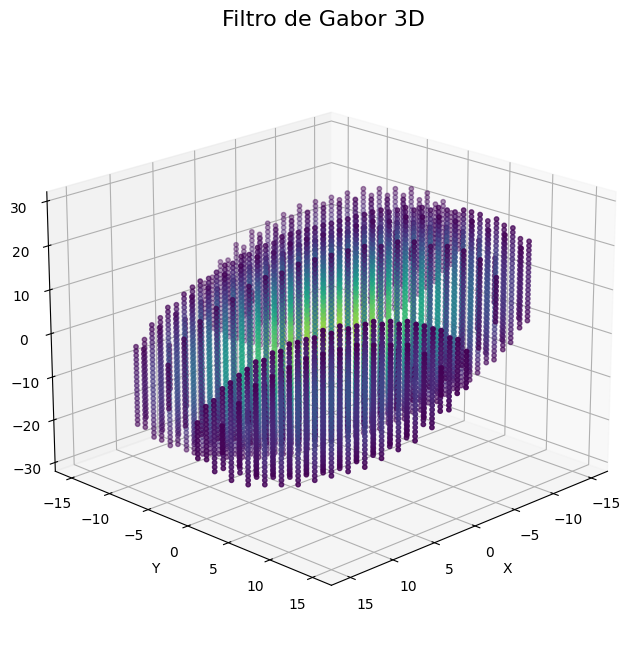

In [80]:
size = 150
sigma = 8.0
theta = np.pi / 4  # Orientação em Z
phi   = np.pi / 4    # Orientação em XY
lamda = 10.0
gamma = 0.5
psi   = 0

# Criar o banco de filtros de Gabor 3D
gabor_kernel = create_gabor_kernel_3d(size, sigma, theta, phi, lamda, gamma, psi, type='real')
plot_gabor_3d(gabor_kernel)

# REFERENCIAS
[1] [Bilateral Filtering: Theory and Applications](https://sites.units.it/ramponi/teaching/DIP/DIPmaterials/z08_Bilateral_filter.pdf)

[2] [Non-Local Means Denoising](https://www.ipol.im/pub/art/2011/bcm_nlm/article.pdf)

[3] [GaborKernel -- openCV sample](https://stackoverflow.com/questions/30071474/opencv-getgaborkernel-parameters-for-filter-bank)

[4] []()

[5] []()

[6] []()

[7] []()